# MMM-Oxford 2x2 SARS-CoV-2 truth set

Comparing SARS2-positive samples from a mixture of cultured and high Ct OUH clinical samples using combinations of:
1. Nanopore and Illumina sequencing
2. ARTIC v3 amplicon sequencing and SISPA whole genome amplification

There are three subsets for testing purposes:
1. **`core`** subset of 12(x4) samples with high coverage sequences representing all amplification and platform combinations
2. **`lineage`** subset of 25(x2) lineage-distinct samples with high coverage ARTIC v3 (ONT and Illumina) representation
3. **`repro`** subset of 10(x2) ONT samples in duplicate and 11(x2) Illumina samples in duplicate with high coverage ARTIC v3 representation

---

## Notes

### Field descriptions

- `name`: Primary identifier comprising `class_`, `sample` and `replicate`
- `class_`: Concatenation of organisation, `amplification` method and sequencing `platform`
    - `{'mmm-artic-ill', 'mmm-artic-ont', 'mmm-sispa-ill', 'mmm-sispa-ont', 'phe-sispa-ill', 'phe-sispa-ont'}`
- `sample`: Truncated SHA1 digest of the original identifying sample name/accession
    - `'s' + str(int(hashlib.sha1(x.encode()).hexdigest(), 16)).str[:6]`
- `replicate`: Replicate of a given `sample`-`platform`-`amplification` combination
- `origin`: Whether derived from tissue culture or a clinical specimen
    - `{'culture', 'clinical'}`
- `amplification`: Amplification methodology
    - `{'artic', 'sispa'}`
- `platform`: Sequencing platform
    - `{'ont', 'ill'}`
- `fastq_filename`: Fastq filename(s) globbed with asterisk. One for ONT, two for Illumina samples:
    - Oxford Nanopore (`platform == 'ont'`)
        - `{name}.fastq.gz` (e.g. `mmm-artic-ont-s10370-1.fastq.gz`)
    - Illumina (`platform == 'ill'`):
        - `{name}_1.fastq.gz` (e.g. `mmm-artic-ill-s10370-1_1.fastq.gz`)
        - `{name}_2.fastq.gz` (e.g. `mmm-artic-ill-s10370-1_2.fastq.gz`)
- `oci_bucket`: Parent bucket in the Oracle Cloud SP3 tenancy

### FASTQ locations
- OCI bucket: `SARS-CoV-2_reference_ox`
- MMM `analysis1`: `/home/ndm.local/bede/covid/truth/fastq_dehosted/`

## Sequencing
- Illumina: MiSeq, 2x250bp
- ONT: GridION, R9.4.1

### QC

- ONT sequences basecalled with Guppy 4.2.3 (HAC)
- Human sequences (`taxid == 9606`) removed using kraken2 2.1.2 and [Standard-16](https://benlangmead.github.io/aws-indexes/k2)
- `cov20_pc` and `median_depth` calculated from minimap2+samtools depths output using reference `MN908947.3`  

### GPAS Comparison

- Viridian and ARTIC protocols for ONT & Illumina
- Pangolin version: 3.1.7
- Nextclade version: ?

### Caveats

- Some samples, generally SISPA have poor coverage
- No delta
- 100bp Illumina samples to be investigated
- Currently fastq only, however Nanopore fast5s are available
- Some erratic indel calling from GPAS Nextclade of unknown version

### Todo

- [x] Create core 2x2 subset
- [x] Join GPAS Viridian and ARTIC outputs
- [ ] Curate truth sequences
    - [ ] `core` subset

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('mmm-2x2-truth.2021-07-16.csv').drop(['pangolin_lineage', 'pangolin_version'], axis=1)
# df = pd.read_csv('mmm-2x2-truth.2021-07-16.csv')
df['oci_bucket'] = 'SARS-CoV-2_reference_ox'

print(f'Length: {df.shape[0]}')
df.head(1)

Length: 309


,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,oci_bucket
0,mmm-artic-ill-s24350-1,mmm-artic-ill,culture,s24350,ill,artic,1,mmm-artic-ill-s24350-1*.fastq.gz,99.771689,8734,SARS-CoV-2_reference_ox


## GPAS outputs for comparison

- Uses outputs from GPAS
    - Viridian
    - ARTIC-based pipelies
        - ONT: Medaka
        - Illumina: Connor lab pipeline (COG)
- Ignores otherwise duplicated records enumerating aln2type types

In [3]:
anal_vir_ill_df = pd.read_csv('res/2x2-ill-viridian.9160f2aa-c89a-4f26-add2-7fd1c8739303/analysis/report/illumina/analysisReport.tsv', sep='\t').drop_duplicates('sample name')
anal_vir_ont_df = pd.read_csv('res/2x2-ont-viridian.969b01b0-7a7e-4966-bece-bd13c2319af1/analysis/report/nanopore/analysisReport.tsv', sep='\t').drop_duplicates('sample name')
anal_vir_df = (pd.concat([anal_vir_ont_df, anal_vir_ill_df])
               .assign(variant_caller='viridian')
               .rename({'sample name': 'name'}, axis=1)
               [['name', 'variant_caller', 'lineage', 'scorpio_call', 'clade', 'pangolin_version', 'substitutions', 'insertions', 'deletions', 'aaSubstitutions', 'aaDeletions']]
               .set_index('name'))

anal_cog_ill_df = pd.read_csv('res/2x2-ill-cog.350d9085-b45d-4849-9d80-47e31c7e70fe/analysis/report/illumina/analysisReport.tsv', sep='\t').drop_duplicates('sample name').assign(variant_caller='cog')
anal_med_ill_df = pd.read_csv('res/2x2-ont-medaka.d058b11c-3fa0-43e5-aef0-3e5e6591ac1a/analysis/report/nanopore/analysisReport.tsv', sep='\t').drop_duplicates('sample name').assign(variant_caller='cog')
anal_art_df = (pd.concat([anal_med_ill_df, anal_cog_ill_df])
               .rename({'sample name': 'name'}, axis=1)
               [['name', 'variant_caller', 'lineage', 'scorpio_call', 'clade', 'pangolin_version', 'substitutions', 'insertions', 'deletions', 'aaSubstitutions', 'aaDeletions']]
               .set_index('name'))

comp_columns = ['lineage', 'scorpio_call', 'clade', 'substitutions', 'deletions', 'insertions', 'aaSubstitutions', 'aaDeletions']
comp_df = (anal_art_df[[*comp_columns]]
           .rename({c:f'art_{c}' for c in comp_columns}, axis=1)
           .join(anal_vir_df[[*comp_columns]]
           .rename({c:f'vir_{c}' for c in comp_columns}, axis=1))
           .replace('None', np.nan).copy())  # Replace Pangolin None lineage calls with NaNs

meta_df = df.join(comp_df, how='inner', on='name')  # Keep only rows with GPAS output
meta_df.shape

(286, 27)

## Lineage distribution

<AxesSubplot:>

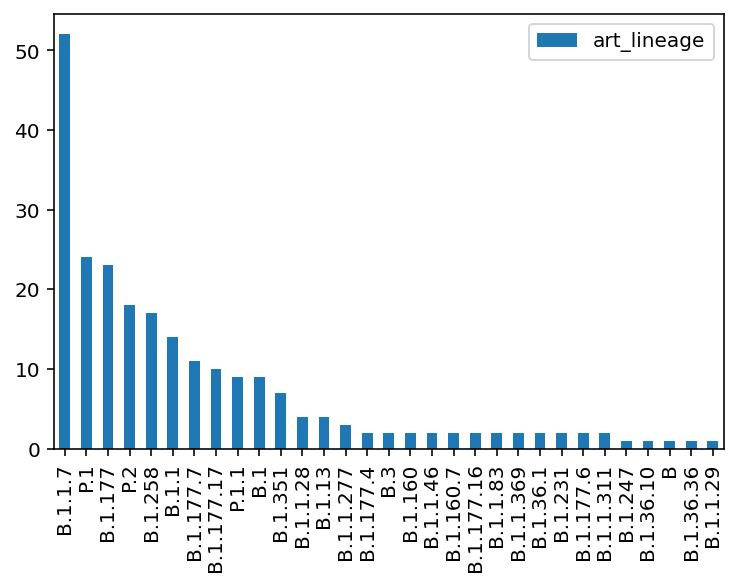

In [4]:
meta_df.art_lineage.value_counts().to_frame().plot.bar()

## 1. Core 2x2 testing subset
- 12 samples sequenced with *high coverage* ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina
- Provided as 4 CSVs with 12 rows each:
    - `testset-core-artic-ont.csv`
    - `testset-core-artic-ill.csv`
    - `testset-core-sispa-ont.csv`
    - `testset-core-sispa-ill.csv`

In [5]:
# ARTIC-ONT + ARTIC-Illumina and >= 95% cov20 
artic_both_platforms_95_df = (df.query("amplification == 'artic' and cov20_pc >= 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['platform']
 .to_frame()
 .query("platform == 2"))
artic_both_platforms_95_df
print(artic_both_platforms_95_df.index.nunique(), 'samples with high coverage ARTIC-ONT and ARTIC-Illumina data')

# 2x2 samples exist
twobytwo_df = (df.groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))
print(twobytwo_df.index.nunique(), 'samples with ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina data')

# 2x2 samples exist and >= 95% cov20
twobytwo_95_df = (df.query("cov20_pc >= 95").groupby('sample')
 .nunique()
 .sort_values(by=['class_', 'sample'], ascending=[False, True])['class_']
 .rename('distinct_amplification_platforms')
 .to_frame()
 .query("distinct_amplification_platforms == 4"))
print(twobytwo_95_df.index.nunique(), 'samples with high coverage ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina data')

twobytwo_95_samples = twobytwo_95_df.index

core_subset_art_ont_df = meta_df.query("cov20_pc >= 95 and amplification == 'artic' and platform == 'ont' and sample in @twobytwo_95_samples").sort_values('cov20_pc', ascending=False).drop_duplicates(['sample', 'amplification']).sort_values(['sample', 'amplification'])
core_subset_art_ill_df = meta_df.query("cov20_pc >= 95 and amplification == 'artic' and platform == 'ill' and sample in @twobytwo_95_samples").sort_values('cov20_pc', ascending=False).drop_duplicates(['sample', 'amplification']).sort_values(['sample', 'amplification'])
core_subset_sis_ont_df = meta_df.query("cov20_pc >= 95 and amplification == 'sispa' and platform == 'ont' and sample in @twobytwo_95_samples").sort_values('cov20_pc', ascending=False).drop_duplicates(['sample', 'amplification']).sort_values(['sample', 'amplification'])
core_subset_sis_ill_df = meta_df.query("cov20_pc >= 95 and amplification == 'sispa' and platform == 'ill' and sample in @twobytwo_95_samples").sort_values('cov20_pc', ascending=False).drop_duplicates(['sample', 'amplification']).sort_values(['sample', 'amplification'])
core_subset_df = pd.concat([core_subset_art_ont_df, core_subset_art_ill_df, core_subset_sis_ont_df, core_subset_sis_ill_df])
core_subset_names = set(core_subset_df.name)

core_subset_art_ont_df.to_csv('testset-core-artic-ont.csv', index=False)
core_subset_art_ill_df.to_csv('testset-core-artic-ill.csv', index=False)
core_subset_sis_ont_df.to_csv('testset-core-sispa-ont.csv', index=False)
core_subset_sis_ill_df.to_csv('testset-core-sispa-ill.csv', index=False)

core_subset_art_ont_df[['oci_bucket', 'name']].to_csv(f'sp3-testset-core-artic-ont.csv', header=False, index=False)
core_subset_art_ill_df[['oci_bucket', 'name']].to_csv(f'sp3-testset-core-artic-ill.csv', header=False, index=False)
core_subset_sis_ont_df[['oci_bucket', 'name']].to_csv(f'sp3-testset-core-sispa-ont.csv', header=False, index=False)
core_subset_sis_ill_df[['oci_bucket', 'name']].to_csv(f'sp3-testset-core-sispa-ill.csv', header=False, index=False)
print(core_subset_df.columns)

52 samples with high coverage ARTIC-ONT and ARTIC-Illumina data
23 samples with ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina data
12 samples with high coverage ARTIC-ONT, ARTIC-Illumina, SISPA-ONT and SISPA-Illumina data
Index(['name', 'class_', 'origin', 'sample', 'platform', 'amplification',
       'replicate', 'fastq_filename', 'cov20_pc', 'median_depth', 'oci_bucket',
       'art_lineage', 'art_scorpio_call', 'art_clade', 'art_substitutions',
       'art_deletions', 'art_insertions', 'art_aaSubstitutions',
       'art_aaDeletions', 'vir_lineage', 'vir_scorpio_call', 'vir_clade',
       'vir_substitutions', 'vir_deletions', 'vir_insertions',
       'vir_aaSubstitutions', 'vir_aaDeletions'],
      dtype='object')


## 2. Between-platform ARTIC v3 testing subset

- **25 ARTIC samples with matched ONT + Illumina**
- Distinct lineages
- Matching ONT+Illumina pairs identified by `matched_pair`
- `cov20_pc > 95`
- `lineage` is not `NaN`
- Now frozen into (`sp3-testset-lineage-ont.csv` and `sp3-testset-lineage-ill.csv`)

In [6]:
lineage_subset_ont_names = set(pd.read_csv('sp3-testset-lineage-ont.csv', header=None, usecols=[1]).squeeze())
lineage_subset_ill_names = set(pd.read_csv('sp3-testset-lineage-ill.csv', header=None, usecols=[1]).squeeze())

lineage_subset_ont_df = meta_df.query("name in @lineage_subset_ont_names").sort_values('sample').reset_index(drop=True).fillna('')
lineage_subset_ill_df = meta_df.query("name in @lineage_subset_ill_names").sort_values('sample').reset_index(drop=True).fillna('')

lineage_subset_ont_df.index.rename('matched_pair', inplace=True)
lineage_subset_ill_df.index.rename('matched_pair', inplace=True)
lineage_subset_df = pd.concat([lineage_subset_ont_df, lineage_subset_ill_df])
lineage_subset_names = set(lineage_subset_df.name)

lineage_subset_ont_df.to_csv('testset-lineage-ont.csv')
lineage_subset_ill_df.to_csv('testset-lineage-ill.csv')

print(lineage_subset_ont_df.shape[0], lineage_subset_ill_df.shape[0])
print(lineage_subset_df.columns)

25 25
Index(['name', 'class_', 'origin', 'sample', 'platform', 'amplification',
       'replicate', 'fastq_filename', 'cov20_pc', 'median_depth', 'oci_bucket',
       'art_lineage', 'art_scorpio_call', 'art_clade', 'art_substitutions',
       'art_deletions', 'art_insertions', 'art_aaSubstitutions',
       'art_aaDeletions', 'vir_lineage', 'vir_scorpio_call', 'vir_clade',
       'vir_substitutions', 'vir_deletions', 'vir_insertions',
       'vir_aaSubstitutions', 'vir_aaDeletions'],
      dtype='object')


## 3. Within-platform ARTIC v3 testing subset

- **10 samples x 2 replicates (ONT)**
- **11 samples x 2 replicates (Illumina)**
- Distinct lineages
- Matched within-platform pairs denoted by `matched_pair` field
- `cov20_pc > 95`
- `lineage` is not `NaN`
- Now frozen into (`sp3-testset-repro-ont.csv` and `sp3-testset-repro-ill.csv`)

In [7]:
repro_subset_ont_names = set(pd.read_csv('sp3-testset-repro-ont.csv', header=None, usecols=[1]).squeeze())
repro_subset_ill_names = set(pd.read_csv('sp3-testset-repro-ill.csv', header=None, usecols=[1]).squeeze())

repro_subset_ont_df = meta_df.query("name in @repro_subset_ont_names").sort_values('sample').reset_index(drop=True).fillna('')
repro_subset_ill_df = meta_df.query("name in @repro_subset_ill_names").sort_values('sample').reset_index(drop=True).fillna('')

repro_subset_ont_df.index.rename('matched_pair', inplace=True)
repro_subset_ill_df.index.rename('matched_pair', inplace=True)
repro_subset_df = pd.concat([repro_subset_ont_df, repro_subset_ill_df])
repro_subset_names = set(repro_subset_df.name)

repro_subset_ont_df.to_csv(f'testset-repro-ont.csv')
repro_subset_ill_df.to_csv(f'testset-repro-ill.csv')

print(repro_subset_ont_df.shape[0], repro_subset_ill_df.shape[0])
print(repro_subset_df.columns)

20 22
Index(['name', 'class_', 'origin', 'sample', 'platform', 'amplification',
       'replicate', 'fastq_filename', 'cov20_pc', 'median_depth', 'oci_bucket',
       'art_lineage', 'art_scorpio_call', 'art_clade', 'art_substitutions',
       'art_deletions', 'art_insertions', 'art_aaSubstitutions',
       'art_aaDeletions', 'vir_lineage', 'vir_scorpio_call', 'vir_clade',
       'vir_substitutions', 'vir_deletions', 'vir_insertions',
       'vir_aaSubstitutions', 'vir_aaDeletions'],
      dtype='object')


## Within-sample, between-pipeline conflict
### Everything

In [8]:
tmp_df = meta_df[['name', 'origin', 'cov20_pc', 'art_lineage', 'vir_lineage', 'art_substitutions', 'vir_substitutions', 'art_deletions', 'vir_deletions', 'art_insertions', 'vir_insertions']].copy()

names_conflict_lineage = {}
names_conflict_sub = {}
names_conflict_del = {}
names_conflict_ins = {}

for r in tmp_df.fillna('').to_dict('records'):
    art_lineage = set(r['art_lineage'].split(','))
    vir_lineage = set(r['vir_lineage'].split(','))
    art_sub = set(r['art_substitutions'].split(','))
    vir_sub = set(r['vir_substitutions'].split(','))
    art_del = set(r['art_deletions'].split(','))
    vir_del = set(r['vir_deletions'].split(','))
    art_ins = set(r['art_insertions'].split(','))
    vir_ins = set(r['vir_insertions'].split(','))
    names_conflict_lineage[r['name']] = ','.join(filter(None, art_lineage^vir_lineage))  # Filter removes empty strings 
    names_conflict_sub[r['name']] = ','.join(filter(None, art_sub^vir_sub))  # Filter removes empty strings 
    names_conflict_del[r['name']] = ','.join(filter(None, art_del^vir_del))  # Filter removes empty strings 
    names_conflict_ins[r['name']] = ','.join(filter(None, art_ins^vir_ins))  # Filter removes empty strings 

tmp_df['conflicting_lineages'] = tmp_df['name'].map(names_conflict_lineage)
tmp_df['conflicting_substitutions'] = tmp_df['name'].map(names_conflict_sub)
tmp_df['conflicting_deletions'] = tmp_df['name'].map(names_conflict_del)
tmp_df['conflicting_insertions'] = tmp_df['name'].map(names_conflict_ins)
tmp_df.fillna('', inplace=True)

# within_sample_conflicts_df = tmp_df[['name', 'origin', 'cov20_pc', 'conflicting_lineages', 'conflicting_substitutions', 'conflicting_deletions', 'conflicting_insertions']].copy()
within_sample_conflicts_df = tmp_df.copy()
print(within_sample_conflicts_df.shape[0])
within_sample_conflicts_df.head(1)

286


,name,origin,cov20_pc,art_lineage,vir_lineage,art_substitutions,vir_substitutions,art_deletions,vir_deletions,art_insertions,vir_insertions,conflicting_lineages,conflicting_substitutions,conflicting_deletions,conflicting_insertions
0,mmm-artic-ill-s24350-1,culture,99.771689,P.1,P.1,"C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,11288-11297,28269:AAAC,28269:AAAC,,,,


### Everything with high coverage and both lineage calls

In [9]:
all_names_passing_qc = df.set_index('name')[['cov20_pc']].join(comp_df.dropna(subset=['art_lineage', 'vir_lineage']), how='inner').index
within_sample_conflicts_passing_df = within_sample_conflicts_df.query("name in @all_names_passing_qc").copy()

print(within_sample_conflicts_passing_df.shape[0])
within_sample_conflicts_passing_df.head(1)

216


,name,origin,cov20_pc,art_lineage,vir_lineage,art_substitutions,vir_substitutions,art_deletions,vir_deletions,art_insertions,vir_insertions,conflicting_lineages,conflicting_substitutions,conflicting_deletions,conflicting_insertions
0,mmm-artic-ill-s24350-1,culture,99.771689,P.1,P.1,"C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,11288-11297,28269:AAAC,28269:AAAC,,,,


### `core` subset
#### Lineage diffs

In [10]:
core_subset_df.query("vir_lineage != art_lineage and vir_lineage != 'None' and art_lineage != 'None'")[['name', 'origin', 'cov20_pc', 'art_lineage', 'vir_lineage', 'art_clade', 'vir_clade']]

,name,origin,cov20_pc,art_lineage,vir_lineage,art_clade,vir_clade
27,mmm-artic-ont-s98244-1,culture,100.000000,P.1.1,P.1,"20J (Gamma, V3)","20J (Gamma, V3)"
26,mmm-artic-ill-s98244-3,culture,99.909347,P.1,P.1.1,"20J (Gamma, V3)","20J (Gamma, V3)"
260,mmm-sispa-ont-s11511-2,clinical,100.000000,B.1.177,NaN,20E (EU1),20A
171,mmm-sispa-ont-s12220-1,clinical,100.000000,B.1.177.7,NaN,20E (EU1),20A
9,mmm-sispa-ont-s24350-1,culture,100.000000,P.1,NaN,"20J (Gamma, V3)","20J (Gamma, V3)"
68,mmm-sispa-ont-s32219-2,culture,100.000000,B.1.351,NaN,"20H (Beta, V2)","20H (Beta, V2)"
275,mmm-sispa-ont-s53667-1,clinical,100.000000,B.1.258,NaN,20A,20A
216,mmm-sispa-ont-s71898-2,clinical,100.000000,B.1,A,20E (EU1),19A
35,mmm-sispa-ont-s98244-3,culture,100.000000,P.1.1,P.1,"20J (Gamma, V3)","20J (Gamma, V3)"
20,mmm-sispa-ill-s59130-3,culture,99.989927,P.1,P.1.1,"20J (Gamma, V3)","20J (Gamma, V3)"


#### Mutation diffs

In [11]:
core_subset_df.groupby('sample')['art_lineage'].nunique()

sample
s11511    1
s12220    1
s12368    2
s16621    1
s24350    1
s32219    1
s53667    1
s59130    2
s64379    1
s71898    2
s82718    1
s98244    2
Name: art_lineage, dtype: int64

In [12]:
(within_sample_conflicts_df
 .query("name in @core_subset_names and (conflicting_substitutions != '' or conflicting_deletions != '' or conflicting_insertions != '')")
 [['name', 'cov20_pc', 'conflicting_substitutions', 'conflicting_deletions', 'conflicting_insertions']])

,name,cov20_pc,conflicting_substitutions,conflicting_deletions,conflicting_insertions
2,mmm-artic-ill-s24350-3,99.969782,,,28269:AAAC
3,mmm-artic-ont-s24350-1,100.000000,T29834A,11082,
6,mmm-sispa-ill-s24350-1,100.000000,T29858A,,
9,mmm-sispa-ont-s24350-1,100.000000,"C241T,T733C,C24642T,G22132T,C23525T,A4998T,A63...","11293-11297,1633,11288-11292",
15,mmm-artic-ont-s59130-1,100.000000,T29834A,,28269:AAAC
20,mmm-sispa-ill-s59130-3,99.989927,T29858A,,28269:AAAC
23,mmm-sispa-ont-s59130-3,100.000000,"C21614T,C21621A,G25088T,T29834A,T733C,C241T,C3...","11288-11297,11082",
26,mmm-artic-ill-s98244-3,99.909347,G11401T,,
27,mmm-artic-ont-s98244-1,100.000000,"T29834A,G11401T",11082,
30,mmm-sispa-ill-s98244-1,99.993285,"T29858A,G11401T",,28269:AAAC


### `lineage` subset
#### Lineage diffs

In [13]:
# within_sample_conflicts_df.query("name in @lineage_subset_names and conflicting_lineages != ''")[['name', 'origin', 'cov20_pc', 'art_lineage', 'vir_lineage']]
lineage_subset_df.query("vir_lineage != art_lineage and vir_lineage != 'None' and art_lineage != 'None'")[['name', 'origin', 'cov20_pc', 'art_lineage', 'vir_lineage', 'art_clade', 'vir_clade']]

,name,origin,cov20_pc,art_lineage,vir_lineage,art_clade,vir_clade
matched_pair,,,,,,,
6,mmm-artic-ont-s12152-1,clinical,99.959710,B.1.1,B.1.1.277,20B,20B
11,mmm-artic-ont-s14131-1,clinical,100.000000,B,B.1.36.10,19A,19A
11,mmm-artic-ill-s14131-1,clinical,98.784582,B.1.36.10,B,19A,19A


#### Mutation diffs

In [14]:
(within_sample_conflicts_df
 .query("name in @lineage_subset_names and (conflicting_substitutions != '' or conflicting_deletions != '' or conflicting_insertions != '')")
 [['name', 'cov20_pc', 'conflicting_substitutions', 'conflicting_deletions', 'conflicting_insertions']])

,name,cov20_pc,conflicting_substitutions,conflicting_deletions,conflicting_insertions
1,mmm-artic-ill-s24350-2,99.969782,,,28269:AAAC
3,mmm-artic-ont-s24350-1,100.000000,T29834A,11082,
13,mmm-artic-ill-s59130-2,99.909347,,,28269:AAAC
15,mmm-artic-ont-s59130-1,100.000000,T29834A,,28269:AAAC
65,mmm-artic-ont-s32219-1,99.462799,,11082,
87,mmm-artic-ont-s14305-1,100.000000,,11082,
89,mmm-artic-ont-s99011-1,100.000000,,11082,
91,mmm-artic-ont-s12466-1,100.000000,,11082,
93,mmm-artic-ont-s10370-1,100.000000,C21575T,"21575,11082",
97,mmm-artic-ont-s60021-1,100.000000,,11082,


### `repro` subset
#### Lineage diffs

In [15]:
repro_subset_df.query("vir_lineage != art_lineage and vir_lineage != 'None' and art_lineage != 'None'")[['name', 'origin', 'cov20_pc', 'art_lineage', 'vir_lineage', 'art_clade', 'vir_clade']]

,name,origin,cov20_pc,art_lineage,vir_lineage,art_clade,vir_clade
matched_pair,,,,,,,
5,mmm-artic-ont-s12152-1,clinical,99.95971,B.1.1,B.1.1.277,20B,20B
16,mmm-artic-ont-s59130-2,culture,100.00000,P.1.1,P.1,"20J (Gamma, V3)","20J (Gamma, V3)"


#### Mutation diffs

In [16]:
(within_sample_conflicts_df
 .query("name in @repro_subset_names and (conflicting_substitutions != '' or conflicting_deletions != '' or conflicting_insertions != '')")
 [['name', 'cov20_pc', 'conflicting_substitutions', 'conflicting_deletions', 'conflicting_insertions']]).sort_values('name')

,name,cov20_pc,conflicting_substitutions,conflicting_deletions,conflicting_insertions
85,mmm-artic-ill-s14305-2,96.813725,T17007C,,
1,mmm-artic-ill-s24350-2,99.969782,,,28269:AAAC
2,mmm-artic-ill-s24350-3,99.969782,,,28269:AAAC
267,mmm-artic-ill-s53667-1,99.486301,C22879A,,
13,mmm-artic-ill-s59130-2,99.909347,,,28269:AAAC
207,mmm-artic-ill-s71898-1,100.000000,"G29688A,C29696A",,
254,mmm-artic-ont-s11511-2,100.000000,,11082,
77,mmm-artic-ont-s12142-2,100.000000,,11082,
134,mmm-artic-ont-s12152-1,99.959710,"T10722C,G28881A,G28882A,G6352T,C6445T,G28883C,...",11082,
135,mmm-artic-ont-s12152-2,99.560167,,21639,


## Everything

In [17]:
meta_df.to_csv('meta.csv', index=False)
meta_df

,name,class_,origin,sample,platform,amplification,replicate,fastq_filename,cov20_pc,median_depth,...,art_aaSubstitutions,art_aaDeletions,vir_lineage,vir_scorpio_call,vir_clade,vir_substitutions,vir_deletions,vir_insertions,vir_aaSubstitutions,vir_aaDeletions
0,mmm-artic-ill-s24350-1,mmm-artic-ill,culture,s24350,ill,artic,1,mmm-artic-ill-s24350-1*.fastq.gz,99.771689,8734,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,28269:AAAC,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"
1,mmm-artic-ill-s24350-2,mmm-artic-ill,culture,s24350,ill,artic,2,mmm-artic-ill-s24350-2*.fastq.gz,99.969782,2474,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,NaN,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"
2,mmm-artic-ill-s24350-3,mmm-artic-ill,culture,s24350,ill,artic,3,mmm-artic-ill-s24350-3*.fastq.gz,99.969782,7507,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,NaN,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"
3,mmm-artic-ont-s24350-1,mmm-artic-ont,culture,s24350,ont,artic,1,mmm-artic-ont-s24350-1*.fastq.gz,100.000000,961,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...","11082,11288-11297",NaN,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"
4,mmm-artic-ont-s24350-2,mmm-artic-ont,culture,s24350,ont,artic,2,mmm-artic-ont-s24350-2*.fastq.gz,100.000000,2956,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...","1633,11082,11288-11297",NaN,"N:P80R,N:R203K,N:G204R,ORF1a:K456X,ORF1a:S1188...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"
5,mmm-artic-ont-s24350-3,mmm-artic-ont,culture,s24350,ont,artic,3,mmm-artic-ont-s24350-3*.fastq.gz,100.000000,4068,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...","11082,11288-11297",NaN,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"
6,mmm-sispa-ill-s24350-1,mmm-sispa-ill,culture,s24350,ill,sispa,1,mmm-sispa-ill-s24350-1*.fastq.gz,100.000000,11651,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,28269:AAAC,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"
7,mmm-sispa-ill-s24350-2,mmm-sispa-ill,culture,s24350,ill,sispa,2,mmm-sispa-ill-s24350-2*.fastq.gz,100.000000,9957,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,28269:AAAC,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-"
8,mmm-sispa-ill-s24350-3,mmm-sispa-ill,culture,s24350,ill,sispa,3,mmm-sispa-ill-s24350-3*.fastq.gz,99.996642,7626,...,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G3676-,ORF1a:F3677-",P.1,Gamma (P.1-like),"20J (Gamma, V3)","C241T,T733C,C2749T,C3037T,C3828T,A5648C,A6319G...",11288-11297,28269:AAAC,"N:P80R,N:R203K,N:G204R,ORF1a:S1188L,ORF1a:K179...","ORF1a:S3675-,ORF1a:G